# Northwestern County Housing Renovation Analysis

Author: Armun Shakeri

# Overview

This project analyzes housing renovations and how renovations might increase the value of a property owners home. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to sell their homes, home renovations might be a way homeowners can increase their property value. This project analyzes these renovations and explores if they do have a positive increase on the house's value. 

# Data Understanding

The following data is imported from KC housing data and shows different information about homes such as the date a home was sold, price, bedrooms...etc. For this project we will only use some of the data available, others will be removed.

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [3]:
# this shows information regarding variables in kc dataframe 
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Below we drop values that are irrelevant towards first time hombe buyer analysis 
kc = kc.drop(['date', 'view', 'sqft_above', 'sqft_basement', 'zipcode', 'sqft_living15', 
        'sqft_lot15', 'waterfront', 'grade'], axis=1)
kc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built,yr_renovated,lat,long
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,1955,0.0,47.5112,-122.257
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,1951,1991.0,47.7210,-122.319
2,5631500400,180000.0,2,1.00,770,10000,1.0,Average,1933,NaN,47.7379,-122.233
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,1965,0.0,47.5208,-122.393
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,1987,0.0,47.6168,-122.045


In [5]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            21597 non-null  int64  
 1   price         21597 non-null  float64
 2   bedrooms      21597 non-null  int64  
 3   bathrooms     21597 non-null  float64
 4   sqft_living   21597 non-null  int64  
 5   sqft_lot      21597 non-null  int64  
 6   floors        21597 non-null  float64
 7   condition     21597 non-null  object 
 8   yr_built      21597 non-null  int64  
 9   yr_renovated  17755 non-null  float64
 10  lat           21597 non-null  float64
 11  long          21597 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 2.0+ MB


In [6]:
# Here we drop all Na values. 
kc=kc.dropna()

In [7]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4, and greater than 2 floors will also be removed. 
kc = kc[kc.price<=1000000]
kc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built,yr_renovated,lat,long
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,1955,0.0,47.5112,-122.257
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,1951,1991.0,47.7210,-122.319
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,1965,0.0,47.5208,-122.393
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,1987,0.0,47.6168,-122.045
6,1321400060,257500.0,3,2.25,1715,6819,2.0,Average,1995,0.0,47.3097,-122.327


In [8]:
# changed year renovated from float64 to int
kc.yr_renovated=kc.yr_renovated.astype(int)

In [9]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16562 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            16562 non-null  int64  
 1   price         16562 non-null  float64
 2   bedrooms      16562 non-null  int64  
 3   bathrooms     16562 non-null  float64
 4   sqft_living   16562 non-null  int64  
 5   sqft_lot      16562 non-null  int64  
 6   floors        16562 non-null  float64
 7   condition     16562 non-null  object 
 8   yr_built      16562 non-null  int64  
 9   yr_renovated  16562 non-null  int64  
 10  lat           16562 non-null  float64
 11  long          16562 non-null  float64
dtypes: float64(5), int64(6), object(1)
memory usage: 1.6+ MB


In [10]:
kc.sort_values('yr_renovated', ascending=False).head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built,yr_renovated,lat,long
7090,9141100005,285000.0,4,3.50,2770,10505,2.0,Average,1940,2015,47.7412,-122.355
3153,6821100195,830000.0,4,3.00,2020,6000,1.0,Average,1968,2015,47.6563,-122.401
5678,2202500255,335000.0,3,2.00,1210,9926,1.0,Good,1954,2015,47.5731,-122.135
16669,5113000420,420000.0,4,2.75,2400,20000,1.0,Average,1961,2015,47.4556,-122.087
15673,3585900190,825000.0,3,2.50,3400,38400,1.0,Average,1955,2015,47.7611,-122.372


In [18]:
# Build correlation matrix
kc.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated,lat,long
id,1.000000,0.016156,0.015266,0.024357,0.012664,-0.134706,0.032580,0.025986,-0.016378,0.003152,0.021298
price,0.016156,1.000000,0.288002,0.437163,0.604088,0.091373,0.268576,0.056184,0.082008,0.440012,0.080722
bedrooms,0.015266,0.288002,1.000000,0.485767,0.584070,0.023043,0.152195,0.157753,-0.000806,-0.031252,0.139748
bathrooms,0.024357,0.437163,0.485767,1.000000,0.709167,0.059998,0.500847,0.550291,0.020983,-0.015222,0.252390
sqft_living,0.012664,0.604088,0.584070,0.709167,1.000000,0.154349,0.335642,0.356386,0.016162,0.002013,0.293822
sqft_lot,-0.134706,0.091373,0.023043,0.059998,0.154349,1.000000,-0.020456,0.037407,0.008187,-0.095483,0.222693
floors,0.032580,0.268576,0.152195,0.500847,0.335642,-0.020456,1.000000,0.511672,-0.006590,0.037226,0.139525
yr_built,0.025986,0.056184,0.157753,0.550291,0.356386,0.037407,0.511672,1.000000,-0.217406,-0.156352,0.409012
yr_renovated,-0.016378,0.082008,-0.000806,0.020983,0.016162,0.008187,-0.006590,-0.217406,1.000000,0.025151,-0.061955
lat,0.003152,0.440012,-0.031252,-0.015222,0.002013,-0.095483,0.037226,-0.156352,0.025151,1.000000,-0.132058


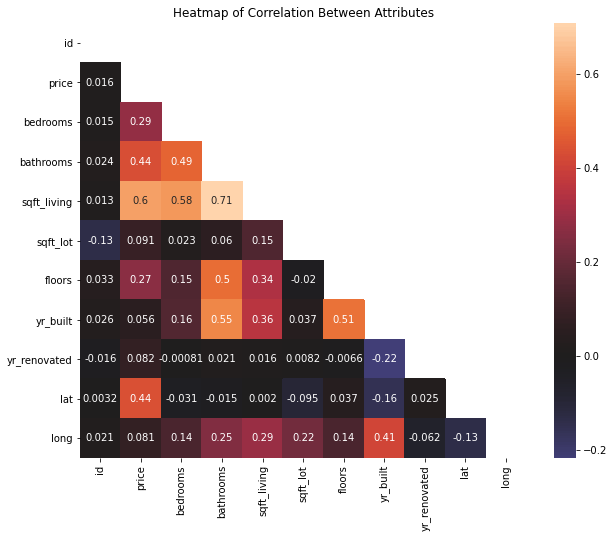

In [37]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(kc.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(corr, dtype=bool)), 
            # Specifies that we want values not just colors
            annot = True,
            center=0);

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# We see below that the highest to lowest correlated are as follows:
# 1) sqft_living vs. bathrooms 
# 2) price vs sqft_living
# 3) bedrooms vs sqft_living

# Data Modeling

In [ ]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

In [ ]:
#fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,5), sharey=True)


#categoricals = ['bedrooms', 'grade', 'bedrooms', 'floors']

#for col, ax in zip(categoricals, axes.flatten()):
#    (kc.groupby(col)            # group values together by column of interest
#        .mean()['price']        # take the mean of the price for each group   
#        .sort_values()          # sort the groups in ascending order
#        .plot                   
#        .bar(ax=ax))            # create a bar graph on the ax
    
#    ax.set_title(col)           # make the title the name of the column

#fig.tight_layout()




In [ ]:
kc['is_renovated']=kc.yr_renovated.map(lambda x : 1 if x > 0 else 0)

In [ ]:
kc.is_renovated.value_counts()

In [ ]:
kc.groupby('is_renovated').mean()

In [ ]:
sns.scatterplot(x="long", y="lat", hue="is_renovated", data=kc)

In [ ]:
kc.corr()